# Automated text classifier and named entity extractor
**Renier Alexander van Staden**


## Webcrawler Implementation

### Domains

The URL's to be crawled are:
- HTML scraping:
    - https://www.abc.net.au/news/business/
    - https://www.abc.net.au/news/sport/
- Content APIs:
    - https://www.abc.net.au/news-web/api/loader/channelrefetch
    
    
The ABC News website contains extensive coverage of both "business" and "sports" domain. The website has dedicated subsections for each of these domains. The subsection that an article is classified under is useful as the category classification can be deteremined from this. The article summary and article text includes all text required for NLP tasks.
    
    
#### Copyright

**Terms of Use**

All content is owned by ABC, but can be used for personal and non-commerical purposes [ABC Terms of Use](https://help.abc.net.au/hc/en-us/articles/360001548096). Webcrawling is not explicity excluded from terms of use.

**Robots.txt**

While some agents and URL's are disallowed, the intended URL's are not disallowed.


#### Other meta-data

Information about companies listed on the ASX is directly downloaded as CSV and saved. This will be used to extract company stock exchange metadata (as an example).

## Webcrawler flow and data wrangling

The following Python packages will be used:
- Requests: to download html or json data from websites
- BeautifulSoup: to parse html
- Regex: to assist with data cleaning
- JSON: to handle JSON data
- Pandas: to create a tabular output
- Matplotlib for plotting

In [19]:
# Import Libraries
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

A list or initial URL's is created and looped through. Each URL is for the main 'business' and 'sports' pages of the ABC News website. Each URL's html page is downloaded and saved to disk. Error handlers are included in case of a runtime error, including HTTP server errors.

In [3]:
# List of URL tuples with url and classification
urls = [('https://www.abc.net.au/news/business/','business'),('https://www.abc.net.au/news/sport/','sport')] 

In [5]:
# Download html of main pages
for url in urls:
    article_category = url[1]
    filename = "abc_" + article_category + "_inital_page.txt"   
    url = url[0]
    
    try:       
        page = requests.get(url) # Get main page
        
        if page.status_code == 200: # if successfull write to file
            with open(filename,mode="w",encoding="utf-8") as file:
                file.write(page.text)
                file.close()
            print('Saved to File: ',article_category)
        else:
            print('HTTP Error')
    except Exception as  e:
        print(e)



Saved to File:  business
Saved to File:  sport


The raw html articles are then parsed using the BeautifulSoup library. Each artilce is included in a 'h3' div element with {"data-component":"CardHeading"} as it's class. The key pieces of information being extracted for each article are:
- Article link (URL): this is extracted from a tag's href in the div
- Article Description: this is extracted from a tag's contents in the div
- Article Category: this is predetermined based on the initial page source URL.

Throughout this application the 'articles" object will be used as a working object to add, remove and manipluate data. The object is a Python dictionary and stored and a JSON.

In [6]:
# Parse main page HTMLs

articles = {}

for url in urls:
    article_category = url[1]
    filename = "abc_" + article_category + "_inital_page.txt"  
    url = url[0]


    with open(filename,mode="r",encoding="utf-8") as file:
        page = file.read()

    soup = BeautifulSoup(page, 'html.parser')
    div = soup.find_all('h3', {"data-component":"CardHeading"}) # tag containing article heading and link

    def is_valid_target_business_link(article_link):
            # Check if the article is a business article (excludes video and radio)
            valid_link = False
            regex_strings = ['/news/\d', '/news/rural/'] # Regex stings for valid url's
            for regex_string in regex_strings:
                x = re.search(regex_string, article_link) 
                if x: valid_link = True
            return valid_link

    # Loop through all divs with articles and extract relevant details from 
    for d in div:
        a_tag = d.find('a') # Get a tag in div
        if a_tag is not None: # check if there is an a tag         
            article_link = a_tag.get('href') # Get Article link from the a_tag            
            valid_link = is_valid_target_business_link(article_link) # Check for valid business url
            if valid_link: # Add to articles list
                article_description = a_tag.contents[0]
                article = {}
                article['description'] = article_description
                article['article_category'] = article_category
                articles[article_link] = article

print('Article Count from Main Pages: ', len(articles))




Article Count from Main Pages:  61


All articles from the main pages were parsed and added to the 'articles' object.

There were only 61 'business' or 'sports' articles across both of the intial page loads. This is not sufficient for NLP. To add more 100 additional articles for each of the 'business' and 'sports' categories will be downloaded using the API called when the "Load More Stories" button (see A. in Figure 2) is clicked. This API URL and paramaters were found by inspecting the Network calls when the "Load More Stories" button is clicked in the Chrome browser.

   ![ABC API Example](img/abc_api_example.PNG)

*Figure 2 - Example of ABC API*

Figure 2, item B. shows an example of the ABC API (/news-web/api/loader/channelrefetch) and its query paramaters that are used to download more articles. 

In [116]:
# Download more Articles (need up to 100) from ABC API
business_api_url = ('https://www.abc.net.au/news-web/api/loader/channelrefetch?name=PaginationArticles&documentId=12785638&prepareParams={%22imagePosition%22:{%22mobile%22:%22right%22,%22tablet%22:%22right%22,%22desktop%22:%22right%22}}&loaderParams={%22pagination%22:{%22size%22:5}}&offset=5&size=100&total=250','business')
sport_api_url = ('https://www.abc.net.au/news-web/api/loader/channelrefetch?name=PaginationArticles&documentId=12785658&prepareParams=%7B%22imagePosition%22:%7B%22mobile%22:%22right%22,%22tablet%22:%22right%22,%22desktop%22:%22right%22%7D%7D&loaderParams=%7B%22pagination%22:%7B%22size%22:5%7D%7D&offset=5&size=100&total=250','sport')

api_urls = [business_api_url,sport_api_url]


for api_url in api_urls:
    article_category = api_url[1]
    filename = "abc_" + article_category + "_additional_articles_raw_json.txt"  
    api_url = api_url[0]
    try:
        response = requests.get(api_url)

        if response.status_code == 200:
            with open(filename,mode="w",encoding="utf-8") as file:
                file.write(response.text)
                file.close()
            print('Saved to File')
        else:
            print('HTTP Error')
    except Exception as  e:
        print(e)



Saved to File
Saved to File


An example of the JSON object returned by the 'contentfetch' API is shown in Figure 3. In Figure 3 the link and article description are highlighted. 

![Returned JSON example](img/abc_api_json_example.PNG)

*Figure 3 - Returned JSON example*

The next section of code parses the link and article description from the JSON object and adds it to the "articles" working object.

In [7]:
# Parse JSON and combine with other data
for url in urls:
    article_category = url[1]
    filename = "abc_" + article_category + "_additional_articles_raw_json.txt"   

    # Open JSON with second list of articles from API
    with open(filename,mode="r",encoding="utf-8") as file:# Open file object
        abc_json = file.read() # Read objecto to string

    abc_json = json.loads(abc_json) # Convert sting to JSON

    # Loop through JSON list, extract article details and apprend to "article" list
    for article in abc_json['collection']:
        #print(article['title']['children'])

        article_link = article['link']['to'] # Get Article link from the a_tag            
        valid_link = is_valid_target_business_link(article_link) # Check for valid business url
        if valid_link:
            article_description = article['title']['children']
            article = {}
            article['description'] = article_description
            article['article_category'] = article_category
            articles[article_link] = article

print('Updated Articles Count: ', len(articles))


# Save Articles to file  
with open("abc_articles.txt",mode="w",encoding="utf-8") as file:
        file.write(json.dumps(articles))
        file.close()
print('Saved to File')        

 


Updated Articles Count:  243
Saved to File


After downloading and validation more articles with the API a total of 243 articles are now available for NLP. The section below downloads the html files for each individal file and saves them to disk for processing later.

In [8]:
# Download article html for all articles in list and save to disk
with open("abc_articles.txt",mode="r",encoding="utf-8") as file:
    articles = json.load(file)# Open file object

base_url = 'https://www.abc.net.au'


print('Articles to process: ', len(articles))
for idx, article in enumerate(articles):
    url = base_url + article # Create Article URL
    
    try:
        page = requests.get(url)
        if page.status_code == 200:

            articles[article]['raw_html'] = page.text
        else:
            print('Server Error:', article)

    except Exception as  e:
        print(e)


# Save Articles to file        
with open("abc_articles_with_raw.txt",mode="w",encoding="utf-8") as file:
        file.write(json.dumps(articles))
        file.close()
print('Saved to File') 




Articles to process:  243
Saved to File


The code section below parses article text from all article html files and adds the article text the the 'articles' object. Any requests that through exceptions below are likely to cause 'NA' values in the final dataset. 'NAs' will have to be dropped before dataset is for NLTK tasks.

In [9]:
# Parse downloaded HTML
# Load Articles        
with open("abc_articles_with_raw.txt",mode="r",encoding="utf-8") as file:
    articles = json.load(file)# Open file object

print('Articles to process: ', len(articles))
for idx, article in enumerate(articles):
    article_text = ''
    page = articles[article]['raw_html']
    soup = BeautifulSoup(page, 'html.parser') 
    div = soup.find_all('div', {'data-component':'LayoutContainer'}) 
    p_tag = div[0].find_all('p')
    try:
        for p in p_tag:
            current_tag_contents = ' '
            has_child = len(p.find_all('a')) != 0
            if has_child:
                a_tag = p.find()
                if isinstance(a_tag.contents[0] ,str):
                    current_tag_contents = a_tag.contents[0]
            else:
                if isinstance(p.contents[0] ,str):
                    current_tag_contents = p.contents[0]

            article_text = ' '.join([article_text,current_tag_contents])
    except Exception as  e:
        print(e)
        print(article)
    article_text = article_text.replace(u'\xa0', u' ') # Replace Unicode non-breaking space with regular space
    articles[article]['article_text'] = article_text # Add extractd article text to json
    del articles[article]['raw_html'] # Remove raw html
    

# Save Articles to file        
with open("abc_articles_with_cleaned.txt",mode="w",encoding="utf-8") as file:
        file.write(json.dumps(articles, ensure_ascii=False))
        file.close()
print('Saved to File') 
    

Articles to process:  243
list index out of range
/news/2021-11-30/australia-matildas-draw-with-usa-in-newcastle/100658892
list index out of range
/news/2021-11-28/teofimo-lopez-vs-george-kambosos-jr-updates-boxing-blog/100655884
list index out of range
/news/2021-11-27/usa-beat-australia-matildas-3-0-sydney/100631628
list index out of range
/news/2021-11-26/afl-rookie-and-preseason-draft-live-blog/100653554
Saved to File


Finally, the 'articles' object is coverted to a Pandas Dataframe and saved a csv for processing by NLP tasks.

In [12]:
# Parse downloaded HTML
# Save Articles to file        
with open("abc_articles_with_cleaned.txt",mode="r",encoding="utf-8") as file:
    articles = json.load(file)# Open file object
   
    
# Convert to CSV and save final output for use in NLP
articles_df = pd.read_json("abc_articles_with_cleaned.txt", orient='index')
articles_df.rename_axis("uri",inplace=True)
articles_df.reset_index(inplace=True)
articles_df.to_csv("abc_articles_df.csv", index=False, sep='|', encoding='utf-16')


The table below shows the first 5 rows of the final table:

In [63]:
articles_df.head()

,uri,article_category,article_text,description
0,/news/2021-11-24/afl-carlton-ceo-brian-cook-te...,sport,Carlton chief executive Brian Cook has tested...,Carlton AFL boss returns positive COVID test
1,/news/2021-11-24/afl-national-draft-kangaroos-...,sport,Outstanding South Australian prospect Jason H...,Kangaroos take Horne-Francis with number one s...
2,/news/2021-11-24/shaun-murphy-amateurs-not-pla...,sport,Professional snooker player Shaun Murphy says...,Former champion says amateur snooker players s...
3,/news/2021-11-24/teen-star-sophie-dwyer-headli...,sport,Giants goal-attack Sophie Dwyer has been elev...,Rising star Sophie Dwyer earns call-up to Aust...
4,/news/2021-11-24/wbbl-brisbane-heat-vs-adelaid...,sport,Adelaide Strikers spinner Amanda-Jade Welling...,Adelaide Strikers stay alive in WBBL finals wi...


 The four fields in the output file are:

|Field Name|Description|
|:---|---|
|uri|This text field has the url for the original article. This field is unique for each record.|
|article_category|This field is the article category ('business' or 'sport')|
|article_text|This field is the full article text / body.|
|description|This is the by-line / article summary that is displayed on the main page.|


**ASX Dataset**

The latest list of ASX companies is downloaded from the ASX's website here:

<https://www2.asx.com.au/markets/trade-our-cash-market/directory>.

### High level EDA

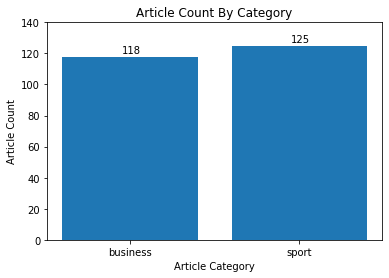

In [65]:
# Plot article counts by category
summary_df = articles_df.groupby(['article_category'])['article_category'].count().to_frame()

fig, ax = plt.subplots()
x = summary_df.index
y = summary_df['article_category']

plt.bar(x, y)
plt.title('Article Count By Category')
plt.ylim(0,140)
plt.xlabel("Article Category")
plt.ylabel("Article Count")
for index,data in enumerate(y):
    plt.text(x=index -0.05 , y =data + 2, s=f"{data}") #, s=f"{data}" , fontdict=dict(fontsize=20)
plt.show()


Further EDA on corpus is performed as part of NLP Tasks in Document 3.

The sample size is relatively evenly balanced between the two categories (classes). This means that further processing to rebalance classes won't be required. Balanced datasets make binary classification models less prone to overfitting.